# Zasady budowania modeli deep learning

## Model

Gdy dane są już gotowe kolejnym krokiem jest odpowiednie zdefiniowanie modelu na którym będziemy pracować. Wykorzystamy do tego bibliotekę [flux.jl](http://fluxml.ai/):

- [Flux](http://fluxml.ai/) jest biblioteką Julii przeznaczoną do tworzenia modeli uczenia maszynowego.
- Jest w całości oparta na Julii, przez co trywialne jest jej modyfikowanie i dostosowywanie do swoich potrzeb. 
- Możliwe jest przy tym wykorzystanie wewnątrz modeli składni, funkcji i makr Julii.
- Przy czym tworzenie całkiem złożonych standardowych modeli jest intuicyjne i szybkie, zazwyczaj zajmują one jedynie kilka linijek.

### Warstwy sieci neuronowej

Jak już wspomnieliśmy wcześniej Flux jest wpełni modyfikowalny i możemy samodzielnie zdefiniować warstwy takiej sieci, korzystając np. z sigmoidalnej funkcją aktywacji:

In [1]:
using Flux

┌ Info: CUDAdrv.jl failed to initialize, GPU functionality unavailable (set JULIA_CUDA_SILENT or JULIA_CUDA_VERBOSE to silence or expand this message)
└ @ CUDAdrv C:\Users\p\.julia\packages\CUDAdrv\mCr0O\src\CUDAdrv.jl:69


In [14]:
W = rand(4, 8)
b = rand(4)
layer₁(x) = 1.0 ./ (1.0.+exp.(-W*x - b))

layer₁ (generic function with 1 method)

In [3]:
W

4×8 Array{Float64,2}:
 0.484911  0.133796  0.408316  0.615787  …  0.128677  0.875562  0.822096
 0.350079  0.35927   0.910204  0.504473     0.183473  0.68881   0.241887
 0.940879  0.709243  0.135829  0.657236     0.450378  0.917757  0.483214
 0.906258  0.38758   0.138697  0.889453     0.126144  0.359157  0.333336

In [4]:
x = rand(8)
layer₁(x)

4-element Array{Float64,1}:
 0.9266919223321637
 0.8745941541923553
 0.885042987857207 
 0.8748811636130117

Przy czym w przypaku najpowszechniejszych funkcji nie musimy ich samodzielnie deklarować. Flux dostarcza  najpopularniejsze funkcje aktywacji i podstawowe typy [warstw modelu](https://fluxml.ai/Flux.jl/stable/models/layers/#Basic-Layers-1):

In [16]:
layer₂(x) = σ.(W * x .+ b)
layer₂(x)

4-element Array{Float64,1}:
 0.7422900941999241
 0.9057858541589381
 0.9326942445057965
 0.9448343273507603

In [17]:
layer₃ = Dense(8,4,σ)
layer₃(x)

4-element Array{Float32,1}:
 0.55730414
 0.3945901 
 0.33650413
 0.41846988

Możemy zdefiniować też własne warstwy jako obiekty:

In [21]:
struct Poly
    W
    V
    b
end

Poly(in::Integer, out::Integer) =
  Poly((randn(out, in)),randn(out, in), (randn(out)))

# Overload call, so the object can be used as a function
(m::Poly)(x) = m.W * x.^2 + m.V*x .+ m.b

a = Poly(10, 5)

a(rand(10)) # => 5-element vector

5-element Array{Float64,1}:
  0.7700566134319377 
  1.3139756985550324 
 -0.23190767646569133
 -2.061138739174586  
  2.199078586911552  

Znów, samo zdefioniowanie warstwy jako obiektu nie wystarczy do wykorzystania wszystkich funkcji Fluxa. Gdy chcemy wykorzystać wbudowane we Fluxa narzędzia do wyznaczania gradientu czy też [liczyć model na GPU](https://fluxml.ai/Flux.jl/stable/gpu/)  musimy jeszcze skorzystać z makra <tt>treelike</tt>:

In [22]:
Flux.@treelike Poly

In [23]:
gpu(a);

Chcąc zbudować model z więcej niż jedną warstwą musimy go odpowiednio zdefiniować:

In [24]:
Layer₁ = Dense(28^2, 32, relu)
Layer₂ = Dense(32, 10)
Layer₃ = softmax

softmax (generic function with 1 method)

Funkcja <tt>Chain</tt> pozwala łączyć w łancuchy dowolne funkcje w Julii:

In [25]:
chain = Chain(x -> x^2, x-> -x)
m₁ = Chain(Layer₁ , Layer₂, Layer₃) 

Chain(Dense(784, 32, relu), Dense(32, 10), softmax)

Możemy zdefiniować model także jako złożenie funkcji:

In [26]:
m₂(x) = Layer₃(Layer₂(Layer₁(x)))

m₂ (generic function with 1 method)

In [27]:
m₃(x) = Layer₁ ∘ Layer₂ ∘ Layer₃  

m₃ (generic function with 1 method)

Albo jako potok:

In [28]:
m₄(x) = Layer₁(x) |> Layer₂  |> Layer₃ 

m₄ (generic function with 1 method)

### Funkcje straty i regularyzacja

[Goodfellow I., Bengio Y., Courville A. (2016), Deep Learning, rozdział 7](http://www.deeplearningbook.org/contents/regularization.html)

Tak jak mówiliśmy na poprzednim wykładzie nie mamy możliwości bezpośredniej optymalizacji wag $\theta$ w modelu. Do procesu uczenia musimy wykorzystać funkcję straty $J(\theta)$.

Funkcję straty możemy zdefiniować samodzielnie:

In [29]:
model = Dense(5,2)
x, y = rand(5), rand(2);
loss(ŷ, y) = sum((ŷ.- y).^2)/ length(y)
loss(model(x), y) 

0.7869596998509756

albo wykorzystać [jedną z zaimplementowanych we Fluxie:](https://github.com/FluxML/Flux.jl/blob/8f73dc6e148eedd11463571a0a8215fd87e7e05b/src/layers/stateless.jl):

In [30]:
Flux.mse(model(x),y)

0.7869596998509756

Jednak samo zdefiniowanie funkcji straty nie wystarczy. Dobry model uczenia maszynowego musi mieć możliwie jak najniższy <b>błąd generalizacji</b>:

[![](https://cdn-images-1.medium.com/max/1600/1*1woqrqfRwmS1xXYHKPMUDw.png)](https://buzzrobot.com/bias-and-variance-11d8e1fee627)


Niestety sieci neuronowe mają tendencję do przeuczania się i w przypadku ich używania konieczne jest wykorzystanie odpowiedniej metody <b>regularyzacji</b>. Dzięki temu możliwe będzie zaproponowanie modelu, który będzie umiał efektywnie aproksymować dane inne niż trenujące.

Do najczęściej wykorzystywanych metod regularyzacji należą:


<b>nakładanie kar na parametry</b>:

Jeden z najczęściej wykorzystywanych sposobów regularyzacji. Polega on na nałożeniu unormowanej kary na parametry funkcji straty: 
     
$\tilde{J}(\theta) = J(\theta) + \alpha\Omega(\theta)$

Najczęściej spotykamy się z postaciami:
- $\Omega(\theta) = ||w||_1 = \sum_i{|w_i|}$     (<i>LASSO</i>,<i>regularyzacja $L_1$</i>)
- $\Omega(\theta) = ||w||_2^2 = \sum_i{w_i^2}$ (<i>regularyzacja Tichonowa</i>, <i>regresja grzbietowa</i>,<i>regularyzacja $L_2$</i>)

Ich implementacja wyglądałaby [następująco](https://fluxml.ai/Flux.jl/stable/models/regularisation/):

In [31]:
using LinearAlgebra

In [32]:
penalty() =  LinearAlgebra.norm(model.W,1) #L1
penalty() =  0.5LinearAlgebra.norm(model.W,2) #L2 lub:
penalty() =  LinearAlgebra.norm(model.W)  #L1

penalty (generic function with 1 method)

In [33]:
penalty()

0.9706237f0

In [34]:
loss(model(x),y) + penalty()

1.75758337185949

czy nawet prościej:

In [35]:
sum(LinearAlgebra.norm,params(model))

0.9706237f0

<b>Bagging (bootstrap aggregating)</b>:

Polega on na losowaniu ze zwracaniem $k$ próbek z wejściowego zbioru danych i szacowaniu na nich $k$  modeli, a następnie uśrednianiu ich rezultatów.

<b>Dropout</b>:

Polega na tworzeniu nowych modeli poprzez usuwanie neuronów z warstw ukrytych z prawdopodobieństwem $p$ w każdej iteracji uczenia. Niech wektor $\mu = [1,1,0,1,1,1,\dots,0,1]$ oznacza neurony wykorzystane do uczenia modelu w danej iteracji $i$. W takim wypadku procedura uczenia sprowadza się do minimalizacji wartości wyrażenia $E_\mu[J(\theta,\mu)]$ dla każdej kolejnej iteracji. Dzięki temu otrzymujemy nieobciążony estymator gradientu bez konieczności generowania i uczenia $k$ modeli tak jak w przypadku baggingu.

Dropout implementuje się we Fluxie jako [warstwę modelu](https://fluxml.ai/Flux.jl/stable/models/layers/#Normalisation-and-Regularisation-1): 

In [38]:
model = Chain(Dense(28^2, 32, relu),
    Dropout(0.1),
Dense(32, 10),
BatchNorm(64, relu),
softmax)

Chain(Dense(784, 32, relu), Dropout(0.1), Dense(32, 10), BatchNorm(64, λ = relu), softmax)

### Optymalizacja sieci

[Goodfellow I., Bengio Y., Courville A. (2016), Deep Learning, rozdział 8](http://www.deeplearningbook.org/contents/optimization.html)

Dobór odpowiedniego algorytmu optymalizacyjnego jest jednym z najważniejszych kroków w trakcie przygotowywania sieci neuronowej. Specyfika procesu ich uczenia powoduje, że proces optymalizacji jest podatny na wiele potencjalnych problemów, między innymi:
- złe uwarunkowanie macierzy.
- występowanie lokalnych minimów, punktów siodłowych, etc.
- zjawiska zanikającego i eksplodującego gradientu

Z tego powodu istnieje wiele różnych algorytmów, które próbują przeciwdziałać wymienionym powyżej problemom. To który z nich powinien być zastosowany zależy tak naprawdę od specyfiki rozpatrywanego przypadku. Do najpopularnieszych należą:
- SGD [(Robbins & Munro 1951)](https://projecteuclid.org/download/pdf_1/euclid.aoms/1177729586)
- SGD z pędem (momentum) [(Polyak, 1964)](http://www.mathnet.ru/php/archive.phtml?wshow=paper&jrnid=zvmmf&paperid=7713&option_lang=eng)
- SGD z pędem Nesterova ([Nesterov, 1983](http://www.cis.pku.edu.cn/faculty/vision/zlin/1983-A%20Method%20of%20Solving%20a%20Convex%20Programming%20Problem%20with%20Convergence%20Rate%20O%28k%5E%28-2%29%29_Nesterov.pdf), [2005](https://www.math.ucdavis.edu/~sqma/MAT258A_Files/Nesterov-2005.pdf))
- AdaGrad (Adaptive Gradient Algorithm) [(Duchi et. al. 2011)](http://www.jmlr.org/papers/volume12/duchi11a/duchi11a.pdf)
- ADAM (Adaptive Moment Estimation) [(Kingma & Ba, 2015)](https://arxiv.org/abs/1412.6980)



Flux umożliwia [wyznaczanie gradientu dowolnej funkcji](https://fluxml.ai/Flux.jl/stable/models/basics/) i przekazanie go do modelu:

In [57]:
f(x) = 3x^2 + 2x + 1

# df/dx = 6x + 2
df(x) = gradient(f, x)[1]

df(2) # 14.0 

# d²f/dx² = 6
d2f(x) = gradient(df, x)[1]

d2f(2) # 6.0 

6

Dotyczy to także dowolnych funkcji (nie tylko tych wyrażonych za pomocą metamatycznej formuły): 

In [59]:
function pow(x, n)
    r = 1
    for i = 1:n
        r *= x
    end
    return r
end

pow (generic function with 1 method)

In [60]:
gradient(x -> pow(x, 3), 5)

(75,)

In [61]:
pow2(x, n) = n <= 0 ? 1 : x*pow2(x, n-1)

pow2 (generic function with 1 method)

In [62]:
gradient(x -> pow2(x, 3), 5)

(75,)

Dzieje się tak dzięki odpowiednio skonstruowanemu mechanizmowi różniczkowania, który efektywnie wykorzystuje charakterystykę języka.  Biblioteka [<tt>Zygote.jl</tt>](https://fluxml.ai/Zygote.jl/latest/) służy do automatycznego różniczkowania w Julii. Wprowadzenie do sposobu jej działania dostępne jest [tutaj](https://github.com/MikeInnes/diff-zoo) i [tutaj](https://arxiv.org/pdf/1810.07951.pdf).

### Automatyczne różniczkowanie

Kluczowym elementem poprawnie działającej biblioteki do uczenia maszynowego jest odpowiedni algorytm wyznaczający gradient funkcji. Jak wiemy z poprzednich zajęć naiwne wyznaczanie gradientu za pomocą definicji pochodnej:
$$\frac{df}{dx} = \lim_{h \to 0}\frac{f(x_0 +h) - f(x_0)}{h}$$
nie jest efektywne numerycznie. W jaki sposób możemy wyznaczać wartości pochodnych?

Okazuje się, że każda, nawet najbardziej skomplikowana funkcja, którą liczymy jest niczym innym niż złożeniem podstawowych operacji arytmetycznych i kilku bazowych funkcji (sin,cos,log,etc.).  Znając podstawowe reguły wyliczania tych pochodnych możemy w efektywny sposób wyznaczyć wartość pochodnej korzystając z reguły łańcuchowej:

$$
\frac{dy}{dx} = \frac{dy_1}{dx}*\frac{dy_2}{dy_1}*\dots*\frac{dy_{n-1}}{dy_{n-2}}*\frac{dy}{dy_{n-1}}
$$

Różniczkowanie można wykonać na dwa sposoby:
#
- <b>do przodu</b> zaczynamy ze znaną wartością $\frac{dy_0}{dx} = \frac{dx}{dx} = 1$. Następnie wyznaczamy wartość dla kolejnej instrukcji  $\frac{dy_1}{dx} = \frac{d_1}{dx} = 1$ i następnie:$\frac{dy_{i+1}}{dy_i}$, aż otrzymamy pełny łańcuch.

- <b>do tyłu</b> zaczynamy ze znaną wartością  $\frac{dy}{dy_n} = \frac{dy}{dy} = 1$. Następnie wyznaczamy wartości: $\frac{dy}{dy_n}$, $\frac{dy}{dy_{n-1}}$, ... $\frac{dy}{dy_1}$, $\frac{dy}{dx}$.  

## Zygote.jl

De facto całe działanie biblioteki <tt>Zygote</tt> opiera się na dwóch kluczowych elementach: makrze <tt>@adjoint</tt> i funkcji <tt>pullback</tt>. 

<tt>pullback</tt> zwraca dwa wyniki, wartość oryginalnej funkcji $y = f(x)$ i wyrażenie $\overline{y}  \frac{dy}{dx}$, gdzie $\overline{y} = \frac{dl}{dy}$ $l$ jest parametrem, który musimy zdefiniować dla dowolnej funkcji $l$.  

In [72]:
using Zygote

In [79]:
y, back = Zygote.pullback(sin, π);

In [77]:
y

1.2246467991473532e-16

In [103]:
back(0.5)

(-0.5,)

W szczególności funkcja <tt>gradient</tt> zakłada, że  $l = y = f(x)$ i $\overline{y} = \frac{dy}{dl} = 1$:

In [109]:
gradient(sin,π) == back(1)

true

Makro <tt>@adjoint</tt> pozwala nam w dowolny sposób modyfikować działanie mechanizmu wyznaczającego pochodne:

In [94]:
using Zygote: @adjoint

In [95]:
minus(a,b) = a - b

minus (generic function with 1 method)

In [97]:
gradient(minus,2,3)

(1, -1)

In [98]:
minus2(a,b) = a - b

minus2 (generic function with 1 method)

In [99]:
@adjoint minus2(a,b) = minus2(a,b), c̄ -> (nothing, -10)

In [101]:
gradient(minus2,2,3)

(nothing, -10)

 Flux ponadto posiada zdefiniowane [podstawowe algorytmy optymalizacyjne:](https://fluxml.ai/Flux.jl/stable/training/optimisers/)

In [ ]:
opt = ADAM(0.0001)

### Uczenie modelu

Flux jest zdolny do kontrolowania całej procedury uczenia, nie musimy robić tego samodzielnie. Służy do tego funkcja <tt>train!</tt>:

In [41]:
Flux.train!(objective, data, opt)

UndefVarError: UndefVarError: objective not defined

Warto jednak zaznaczyć, że pozwala ona na uczenie jedynie przez pojedynczą epokę. Aby móc kontynuować proces uczenia dalej musimy w odpowiedni sposób przystować dane z których korzystamy:

In [42]:
using Base.Iterators: repeated
dataset = repeated((x, y), 200)

Base.Iterators.Take{Base.Iterators.Repeated{Tuple{Array{Float64,1},Array{Float64,1}}}}(Base.Iterators.Repeated{Tuple{Array{Float64,1},Array{Float64,1}}}(([0.8253855127364018, 0.33029358909607787, 0.5824801753925017, 0.5095894084644372, 0.8123625082266968], [0.6417865525141162, 0.7576011000069922])), 200)

albo skorzystać z makra <tt>@epochs</tt>:

In [43]:
Flux.@epochs 2 println("hello")

hello
hello


┌ Info: Epoch 1
└ @ Main C:\Users\p\.julia\packages\Flux\oX9Pi\src\optimise\train.jl:99
┌ Info: Epoch 2
└ @ Main C:\Users\p\.julia\packages\Flux\oX9Pi\src\optimise\train.jl:99


Pozwala ona też na definiowanie wywołań, które pozwolą nam kontrolować przebieg uczenia.

In [44]:
evalcb = () -> @show(loss(tX, tY))

#12 (generic function with 1 method)

## Przykład

In [45]:
using Flux, Flux.Data.MNIST, Statistics
using Flux: onehotbatch, onecold, crossentropy, throttle
using Base.Iterators: repeated

Zacznijmy od podstaw, wczytajmy i opracujmy zbiór danych na którym będziemy pracowali:

In [49]:

# Classify MNIST digits with a simple multi-layer-perceptron

imgs = MNIST.images()
# Stack images into one large batch
X = hcat(float.(reshape.(imgs, :))...) 

labels = MNIST.labels()
# One-hot-encode the labels
Y = onehotbatch(labels, 0:9) 

10×60000 Flux.OneHotMatrix{Array{Flux.OneHotVector,1}}:
 0  1  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  1  0  0  1  0  1  0  0  0  0     0  0  0  0  0  0  1  0  0  0  0  0
 0  0  0  0  0  1  0  0  0  0  0  0  0     0  0  0  1  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  1  0  0  1  0  1     0  0  0  0  0  0  0  0  1  0  0  0
 0  0  1  0  0  0  0  0  0  1  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 1  0  0  0  0  0  0  0  0  0  0  1  0  …  0  0  0  0  0  1  0  0  0  1  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  1  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     1  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  1  0  0  0  0  0  1  0  0  0  1
 0  0  0  0  1  0  0  0  0  0  0  0  0     0  0  1  0  1  0  0  0  0  0  0  0

Zdefiniujmy model:

In [50]:
m = Chain(
  Dense(28^2, 32, relu),
  Dense(32, 10),
  softmax) 

loss(x, y) = crossentropy(m(x), y)

accuracy(x, y) = mean(onecold(m(x)) .== onecold(y))

dataset = repeated((X, Y), 200)
evalcb = () -> @show(loss(X, Y))
opt = ADAM()

Flux.train!(loss, params(m), dataset, opt, cb = throttle(evalcb, 10))

accuracy(X, Y)

# Test set accuracy
tX = hcat(float.(reshape.(MNIST.images(:test), :))...) 
tY = onehotbatch(MNIST.labels(:test), 0:9) 

accuracy(tX, tY)

loss(X, Y) = 2.3353536f0
loss(X, Y) = 2.1709254f0
loss(X, Y) = 2.020329f0
loss(X, Y) = 1.8676506f0
loss(X, Y) = 1.7200183f0
loss(X, Y) = 1.583041f0
loss(X, Y) = 1.4564956f0
loss(X, Y) = 1.3402474f0
loss(X, Y) = 1.2332063f0
loss(X, Y) = 1.1348826f0
loss(X, Y) = 1.0459137f0
loss(X, Y) = 0.96616536f0
loss(X, Y) = 0.89571327f0
loss(X, Y) = 0.83432454f0
loss(X, Y) = 0.7809237f0
loss(X, Y) = 0.73432285f0
loss(X, Y) = 0.6935205f0
loss(X, Y) = 0.65780884f0
loss(X, Y) = 0.6265953f0
loss(X, Y) = 0.5992262f0
loss(X, Y) = 0.5750267f0
loss(X, Y) = 0.55344534f0
loss(X, Y) = 0.53406984f0
loss(X, Y) = 0.51659596f0
loss(X, Y) = 0.50076187f0
loss(X, Y) = 0.48634902f0
loss(X, Y) = 0.47317097f0
loss(X, Y) = 0.4610759f0
loss(X, Y) = 0.4499293f0
loss(X, Y) = 0.43962362f0
loss(X, Y) = 0.43006173f0
loss(X, Y) = 0.421164f0
loss(X, Y) = 0.4128689f0
loss(X, Y) = 0.40511835f0
loss(X, Y) = 0.39785886f0
loss(X, Y) = 0.39104253f0
loss(X, Y) = 0.38463032f0
loss(X, Y) = 0.37858582f0
loss(X, Y) = 0.37288088f0
loss(X, Y

0.9208

Otrzymane wyniki możemy zapisywać korzystając z biblioteki <tt>BSON</tt>:

In [111]:
using BSON

In [114]:
BSON.@save "MNIST.bson" m

i oczywiście wczytywać:

In [116]:
BSON.@load "MNIST.bson" m

### Strojenie hiperparametrów

Sieć neuronowa potrafi zoptymalizować jedynie wagi $\theta$ funkcji liniowych wykorzystanych do budowy modelu. Pozostałe parametry (funkcje aktywacji, metoda regularyzacji, stopa uczenia, etc.) muszą być przyjęte z góry. Dobrać je można na kilka różnych sposobów:
- wzorując się na literaturze
- zgadując parametry
- tworząc model [zdolny do nauczenia się optymalnej metody uczenia](https://github.com/FluxML/model-zoo/tree/master/other/meta-learning)
- przeszukując odpowiednio przestrzeń hiperparametrów

In [51]:
using PyPlot

┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1273


#### Krata równomierna

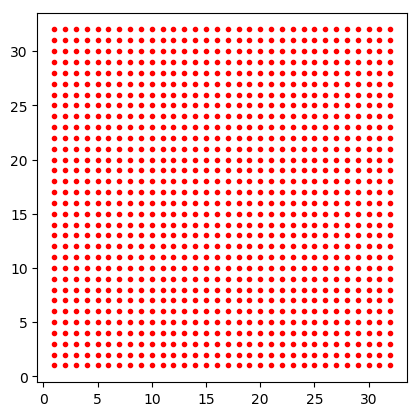

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000035DE7BA8>

In [52]:
p = hcat(sort(repeat(1:32,32)),repeat(1:32,32))
subplot(111, aspect="equal")
plot(p[:,1], p[:,2], "r.")

#### Liczby (pseudo)losowe

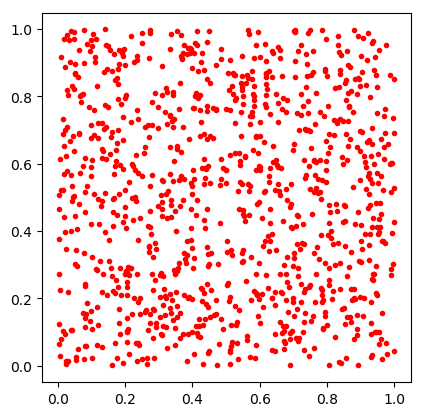

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000062DF62E8>

In [53]:
p = rand(1024,2)
subplot(111, aspect="equal")
plot(p[:,1], p[:,2], "r.")

#### Sekwencje Sobola

┌ Info: Precompiling Sobol [ed01d8cd-4d21-5b2a-85b4-cc3bdc58bad4]
└ @ Base loading.jl:1273


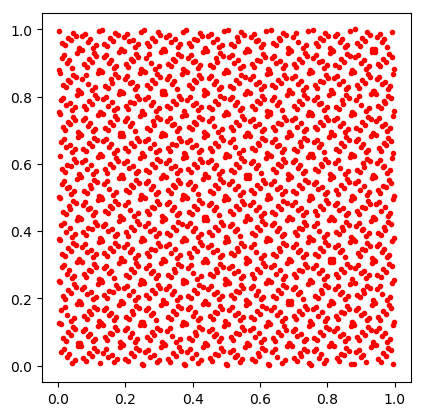

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000631A97B8>

In [54]:
using Sobol
s = SobolSeq(2)
p = hcat([next!(s) for i = 1:2000]...)'
subplot(111, aspect="equal")
plot(p[:,1], p[:,2], "r.")

## Dodatkowa praca domowa

Dokonaj strojenia hiperparametrów sieci omawianej na wykładzie. Sprobuj znaleźć taką, która zapewnia wyższą trafność predykcji.